---

# Decision Trees: Predicting Loan Defaults

In this notebook we will showcase the decision tree machine learning technique. Decision trees work by learning a series of simple classification rules and organizing them into a tree, so that when data outside the test set is introduced, it follows a particular set of decisions through a tree which eventually classifies it.

Decision trees tend to be very popular due to their ease of interpretation and their ability to classify more complex datasets. They are made of up two components: nodes and branches. Nodes can further be divided into three types:
- Root node: This is the topmost node which acts as the input node for feature vectors.
- Decision node: These are nodes where decisions and classifications are evaluated. Multiple decision nodes can be (and often are) visited in succession.
- Leaf node: This node represents the final classification of a peice of data.

We will begin illustrating this technique by attempting to predict loan defaults using the sklearn decision tree library. Load the dataset from Kaggle and use the path to access the file.

---

In [34]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Download latest version
path = kagglehub.dataset_download("wordsforthewise/lending-club")

print("Path to dataset files:", path)


Path to dataset files: C:\Users\kylej\.cache\kagglehub\datasets\wordsforthewise\lending-club\versions\3


---

Use the path that was printed to pass the dataset into a dataframe and reduce the size for faster calculations.

---

In [35]:
# You can download a sample from Kaggle, then read locally
df = pd.read_csv("accepted_2007_to_2018Q4.csv", low_memory=False)

# Reduce size for demo purposes (optional)
df = df.sample(10000, random_state=42)

---

Take a look at the dataframe's structure:

---

In [36]:
df

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,...,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
392949,39651438,NaN,32000.0,32000.0,32000.0,60 months,10.49,687.65,B,B3,Public Service,10+ years,MORTGAGE,120000.0,Verified,Feb-2015,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,919xx,CA,24.05,0.0,Oct-1981,735.0,739.0,0.0,NaN,NaN,20.0,0.0,39687.0,57.8,42.0,w,7181.91,7181.91,...,556496.0,103647.0,64100.0,72197.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1273506,16411620,NaN,9600.0,9600.0,9600.0,36 months,12.99,323.42,C,C1,NaN,NaN,RENT,21900.0,Verified,May-2014,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,331xx,FL,10.03,0.0,Apr-2001,685.0,689.0,1.0,NaN,118.0,13.0,1.0,4509.0,38.9,20.0,w,0.00,0.00,...,11600.0,4509.0,2400.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
324024,45122316,NaN,4000.0,4000.0,4000.0,36 months,6.68,122.93,A,A3,System Analyst,4 years,MORTGAGE,83000.0,Not Verified,Apr-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,major_purchase,Major purchase,333xx,FL,19.53,0.0,Sep-2003,780.0,784.0,0.0,NaN,NaN,16.0,0.0,1564.0,17.2,25.0,w,0.00,0.00,...,222616.0,64253.0,5600.0,76154.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2066630,125356772,NaN,6025.0,6025.0,6025.0,36 months,10.91,197.00,B,B4,Admin assistant,10+ years,RENT,52000.0,Not Verified,Dec-2017,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,021xx,MA,9.16,1.0,Jun-2005,740.0,744.0,1.0,15.0,NaN,11.0,0.0,2706.0,12.8,25.0,w,0.00,0.00,...,32227.0,5559.0,11000.0,11127.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
477199,128490686,NaN,25000.0,25000.0,25000.0,60 months,26.30,752.96,E,E5,Coordinator,10+ years,OWN,65000.0,Verified,Feb-2018,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,926xx,CA,36.26,0.0,Jul-1999,715.0,719.0,1.0,37.0,NaN,19.0,0.0,49461.0,24.7,33.0,w,21954.14,21954.14,...,257219.0,97647.0,179400.0,65719.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

---

Let's restructure the dataframe to only include features that we care about.

---

In [37]:
features = ['loan_amnt', 'term', 'int_rate', 'grade', 'home_ownership', 'annual_inc', 'purpose']
target = 'loan_status'

df = df[features + [target]]
df

,loan_amnt,term,int_rate,grade,home_ownership,annual_inc,purpose,loan_status
392949,32000.0,60 months,10.49,B,MORTGAGE,120000.0,debt_consolidation,Current
1273506,9600.0,36 months,12.99,C,RENT,21900.0,debt_consolidation,Fully Paid
324024,4000.0,36 months,6.68,A,MORTGAGE,83000.0,major_purchase,Fully Paid
2066630,6025.0,36 months,10.91,B,RENT,52000.0,debt_consolidation,Fully Paid
477199,25000.0,60 months,26.30,E,OWN,65000.0,debt_consolidation,Current
...,...,...,...,...,...,...,...,...
1030963,4000.0,36 months,5.32,A,MORTGAGE,105000.0,debt_consolidation,Fully Paid
683316,12000.0,36 months,13.67,C,OWN,50000.0,debt_consolidation,Fully Paid
2084322,19200.0,36 months,7.35,A,MORTGAGE,66700.0,debt_consolidation,Current
2189979,4800.0,36 months,19.99,D,RENT,53000.0,credit_card,Current


---

We can also change the target labels to define the target variable as either 1 or 0. Let's go ahead and remove rows with empty values and encode catagorical features numerically.

---

In [38]:
df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]
df['target'] = np.where(df['loan_status'] == 'Charged Off', 1, 0)

df.dropna(inplace=True)

# Encode categorical features
for col in ['term', 'grade', 'home_ownership', 'purpose']:
    df[col] = pd.factorize(df[col])[0]

df

C:\Users\kylej\AppData\Local\Temp\ipykernel_15988\1116137304.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = np.where(df['loan_status'] == 'Charged Off', 1, 0)
C:\Users\kylej\AppData\Local\Temp\ipykernel_15988\1116137304.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)
C:\Users\kylej\AppData\Local\Temp\ipykernel_15988\1116137304.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

,loan_amnt,term,int_rate,grade,home_ownership,annual_inc,purpose,loan_status,target
1273506,9600.0,0,12.99,0,0,21900.0,0,Fully Paid,0
324024,4000.0,0,6.68,1,1,83000.0,1,Fully Paid,0
2066630,6025.0,0,10.91,2,0,52000.0,0,Fully Paid,0
1975547,20000.0,0,9.49,2,1,100000.0,0,Fully Paid,0
302723,1000.0,0,8.18,2,0,23000.0,0,Fully Paid,0
...,...,...,...,...,...,...,...,...,...
1158716,25725.0,1,24.08,5,0,60500.0,0,Charged Off,1
1697801,5000.0,0,12.74,0,0,36000.0,0,Fully Paid,0
657059,7200.0,0,5.32,1,1,80000.0,0,Fully Paid,0
1030963,4000.0,0,5.32,1,1,105000.0,0,Fully Paid,0


---

Split the data into training and testing data.

---

In [39]:
from sklearn.model_selection import train_test_split

X = df[features]
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=42)


---

Time to train our model! We can control the maximum depth of our tree to prevent overfitting. We can also pass a random state so that you can replicate the results exactly.

---

In [ ]:
tree = DecisionTreeClassifier(max_depth=4, random_state=42)
tree.fit(X_train, y_train)



DecisionTreeClassifier(max_depth=4, random_state=42)

---

Test the model and print key performance metrics. We can also nicely print a copy of our tree to see exactly where it's making its decisions!

---

Accuracy: 0.7897822445561139

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.97      0.88       953
           1       0.40      0.08      0.13       241

    accuracy                           0.79      1194
   macro avg       0.60      0.52      0.51      1194
weighted avg       0.72      0.79      0.73      1194



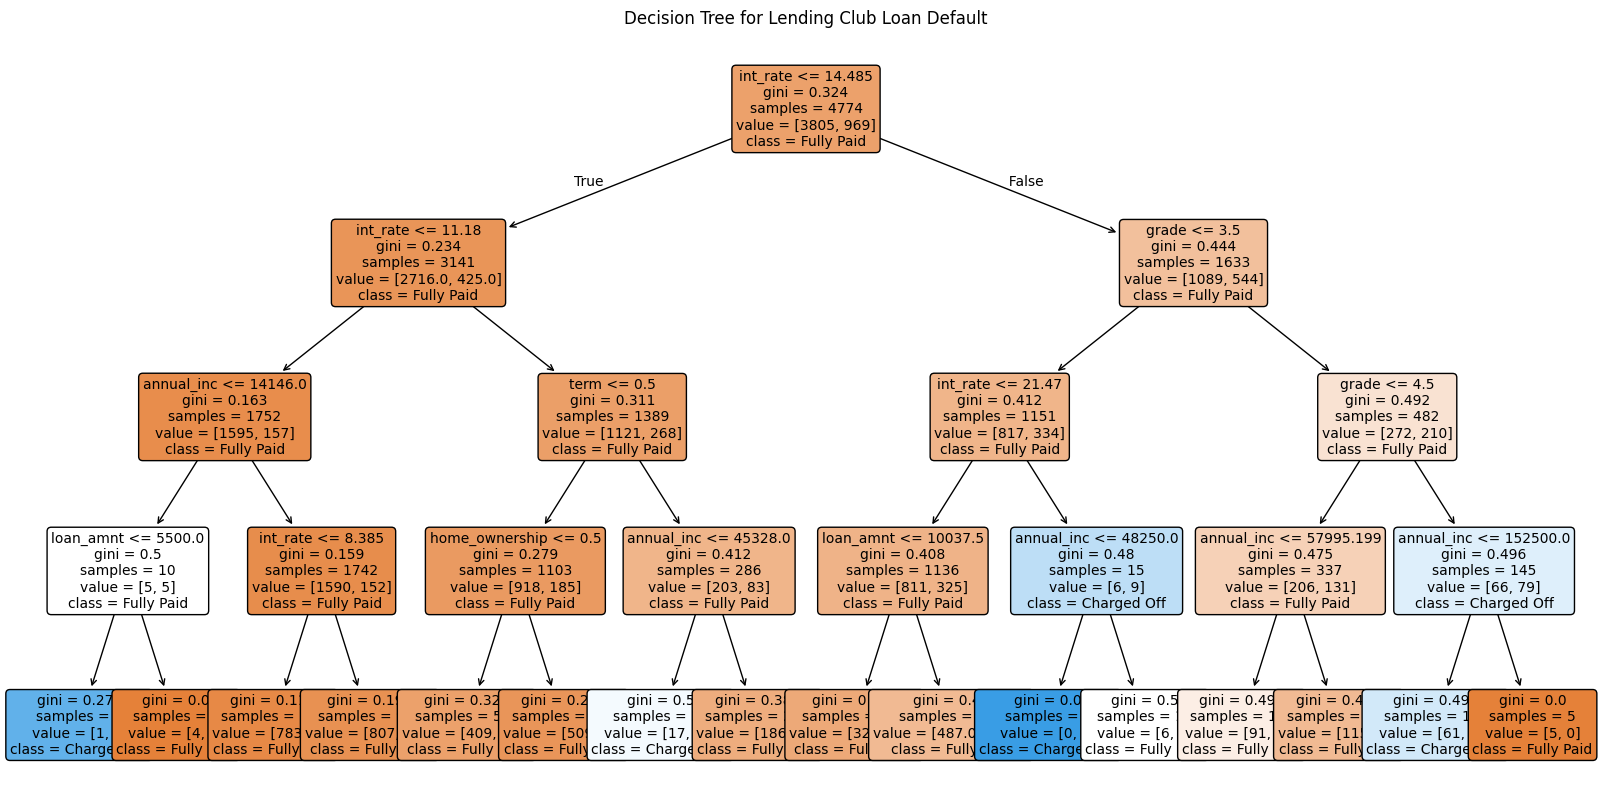

In [41]:
y_pred = tree.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=X.columns, class_names=["Fully Paid", "Charged Off"],
          filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree for Lending Club Loan Default")
plt.show()



---

We can now inspect our model to see how it did. It's acheiving about 78% accuracy, which, while not perfect, is far better than randomly guessing. Since the dataset has too many dimensions to easily print, it's hard to see the decision boundaries for ourselves on a plane, but the decision trees are nice in that we can still see the exact "logical" decision boundary!

---